In [1]:
from pathlib import Path

import os, sys
from geopy.geocoders import GoogleV3, Nominatim
import geopandas as gpd
import pandas as pd

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim
from SCanalyzer.busSim.manager import LocalManager
from shapely.geometry import Point
from matplotlib.lines import Line2D

manger init
mangager register
mangager register


In [2]:
%matplotlib inline

In [3]:
OUT_PATH = "/tmp/output"
DAY = "monday"

START_TIME = "06:55:00"
ELAPSE_TIME = "00:15:00"

DATA_PATH = "../data/minneapolis_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"

START_LOCATION = "Whispering Oaks"

AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12
city = gpd.read_file("../data/plot/background/madison-shp").to_crs(epsg=3174)
lakes = gpd.read_file("../data/plot/background/water-shp").to_crs(epsg=3174)
street = gpd.read_file("../data/plot/background/street-shp").to_crs(epsg=3174)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

sc = SCanalyzer(DATA_PATH)

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

stops_meter exists


In [10]:
cache = {}
def geocode(addr):
    # if not "madison" in addr.lower():
    #     addr += ", Madison WI"
    # if not addr in cache:
    cache[addr] = geolocator.geocode(addr)
    return cache[addr]

In [11]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

In [12]:
gdf = None
def plot(starts=[]):      
    # ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
    # lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
    # city.plot(color="black", alpha=0.05, ax=ax, zorder=2)
    # street.plot(color="black", alpha=0.03, ax=ax, zorder=3)

    leg_lines = []
    leg_text = []
    
    colors = ["orange", "blue", "green", "yellow"]
    
    zorder = 4
    
    bubbles = []
    for i, addr in enumerate(starts):
        global gdf
        print(addr)
        zorder += 10
        location = geocode(addr)
        lat, lon = (location.latitude, location.longitude)
        # # check if the point is indeed in Madison
        # if lat > max_lat or lat < min_lat or lon > max_lon or lon < min_lon:
        #     print(lat, lon)
        #     print(f"Looks like {start} is not in madison.")
        #     continue
        # gdf = busSim.get_gdf()
        gdf = busSim.get_gdf(start_point=(lat, lon))
        if gdf is None:
            print(f'illegal start {addr}')
            continue
        gdf = gdf.to_crs(epsg=3174)
        
        color = colors[i % len(colors)]
        bubble = flatten(gdf)
        bubble["color"] = color
        bubbles.append(bubble)
        bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
        gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)
        start = gpd.GeoSeries([Point(lon, lat)],crs=4326).to_crs(3174)
        start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100)
        
        leg_lines.append(Line2D([0], [0], color=color, lw=4))
        leg_text.append(addr)
        
    df = pd.concat(bubbles)
    df.plot(alpha=0.2, ax=ax, color=df["color"], zorder=zorder)

    leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("white")

    return bubbles
    # ax.set_axis_off()
    
def demo(addrs_str):
    return plot([s.strip() for s in addrs_str.split("\n") if s.strip() != ""])

Whispering Oaks
illegal start Whispering Oaks


ValueError: No objects to concatenate

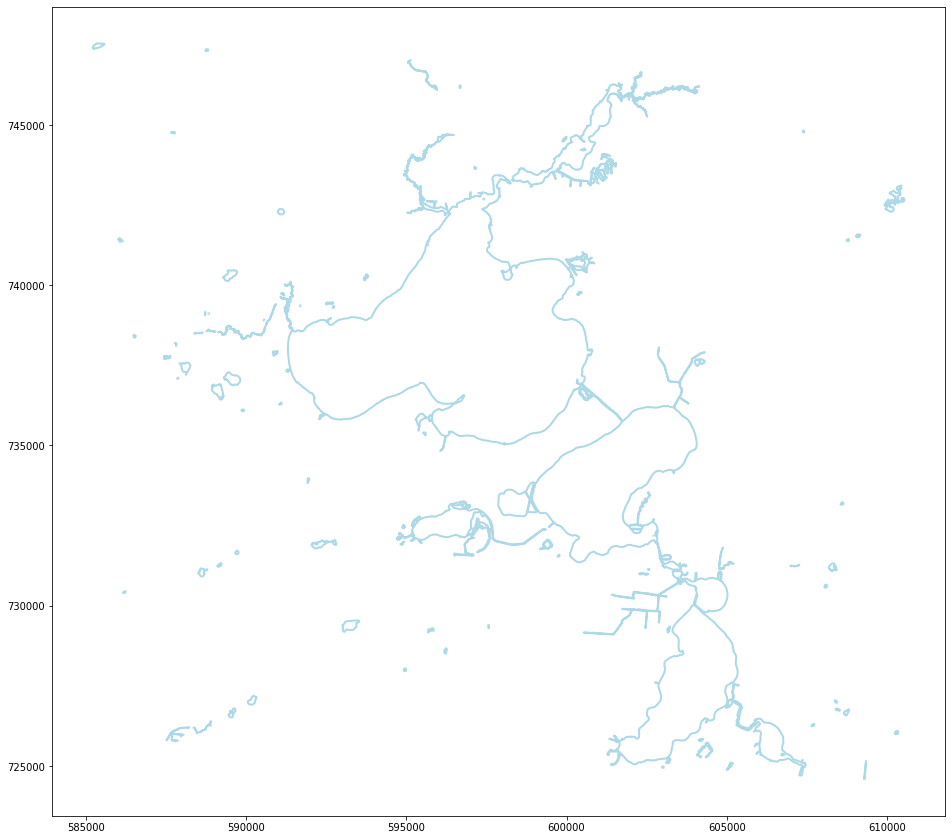

In [13]:
bubbles = demo("Whispering Oaks")

In [3]:
1.113893e+07/(1e+06)

11.13893

In [8]:
bubbles[0].geometry.area

0    1.113893e+07
dtype: float64

In [20]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

def gen_busSim(data_path=None, out_path=None, day=None, start_time=None, elapse_time=None, avg_walking_speed=None, max_walking_min=None):
    manager = LocalManager(data_path, out_path, None)
    busSim = BusSim(manager, day, start_time, elapse_time, avg_walking_speed, max_walking_min)
    return busSim

def get_area(start_point=None, start_location=None, busSim=None, crs=3174):
    geolocator = Nominatim(user_agent="area_demo")
    location = geolocator.geocode(start_location)
    lat, lon = (location.latitude, location.longitude)
    gdf = busSim.get_gdf(start_point=(lat, lon))
    if gdf is None:
        return 0
    gdf = gdf.to_crs(epsg=3174)
    bubble = flatten(gdf.geometry)
    return bubble.geometry.area/10**6


In [21]:
start_times = ["04:55:00","04:57:00"]
DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"

START_LOCATION = "Whispering Oaks"
ELAPSE_TIME = "00:20:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

busSims = []
for start_time in start_times:
    busSims.append(gen_busSim(DATA_PATH,OUT_PATH, DAY, start_time, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN))

areas = []
for busSim in busSims:
    areas.append(get_area(start_location=START_LOCATION, busSim=busSim))

['stop_times.txt', 'stops.txt', 'trips.txt', 'calendar.txt', 'shapes.txt', 'routes.txt', 'stops-3174.txt', 'stops1.txt', 'stops_meter.txt', 'stops_meter.txt', 'stops_meter.txt', 'stops_meter.txt']
new Stops df    stop_id stop_name   stop_lat   stop_lon         stop_x        stop_y
0        1    start1  43.067728 -89.412681  303558.471672  4.771161e+06
1        2    start2  43.070048 -89.409206  303848.821732  4.771411e+06
2        3    start3  43.073183 -89.409034  303872.828936  4.771758e+06
3        4    start4  43.073339 -89.400752  304547.616248  4.771756e+06
4        5    start5  43.073183 -89.394014  305095.704211  4.771723e+06
5        6    start6  43.076694 -89.389003  305514.791885  4.772102e+06
6        7    start7  43.087586 -89.373383  306820.687962  4.773275e+06
7        8    start8  43.094058 -89.362203  307750.964519  4.773968e+06
8        9    start9  43.100466 -89.354070  308432.886578  4.774661e+06
['stop_times.txt', 'stops.txt', 'trips.txt', 'calendar.txt', 'shapes.t

In [31]:
times = []
for hour in range(5, 11):
    for minute in range(0, 60, 5):
        times.append('{:02d}:{:02d}:00'.format(hour, minute))

In [32]:
times

['05:00:00',
 '05:05:00',
 '05:10:00',
 '05:15:00',
 '05:20:00',
 '05:25:00',
 '05:30:00',
 '05:35:00',
 '05:40:00',
 '05:45:00',
 '05:50:00',
 '05:55:00',
 '06:00:00',
 '06:05:00',
 '06:10:00',
 '06:15:00',
 '06:20:00',
 '06:25:00',
 '06:30:00',
 '06:35:00',
 '06:40:00',
 '06:45:00',
 '06:50:00',
 '06:55:00',
 '07:00:00',
 '07:05:00',
 '07:10:00',
 '07:15:00',
 '07:20:00',
 '07:25:00',
 '07:30:00',
 '07:35:00',
 '07:40:00',
 '07:45:00',
 '07:50:00',
 '07:55:00',
 '08:00:00',
 '08:05:00',
 '08:10:00',
 '08:15:00',
 '08:20:00',
 '08:25:00',
 '08:30:00',
 '08:35:00',
 '08:40:00',
 '08:45:00',
 '08:50:00',
 '08:55:00',
 '09:00:00',
 '09:05:00',
 '09:10:00',
 '09:15:00',
 '09:20:00',
 '09:25:00',
 '09:30:00',
 '09:35:00',
 '09:40:00',
 '09:45:00',
 '09:50:00',
 '09:55:00',
 '10:00:00',
 '10:05:00',
 '10:10:00',
 '10:15:00',
 '10:20:00',
 '10:25:00',
 '10:30:00',
 '10:35:00',
 '10:40:00',
 '10:45:00',
 '10:50:00',
 '10:55:00']